In [24]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql
from scipy.optimize import minimize, differential_evolution
import numpy as np

In [2]:
def calc_natural_days(start_date, end_date):
    
    # 将字符串转换为datetime对象
    start_dt = datetime.strptime(start_date, '%Y%m%d')
    end_dt = datetime.strptime(end_date, '%Y%m%d')
    
    # 计算日期差值
    days_diff = (end_dt - start_dt).days
    
    return days_diff

In [3]:
def black76_price(F, K, T, r, sigma, option_type='call'):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif option_type == 'put':
        return np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    else:
        raise ValueError("option_type must be 'call' or 'put'")

In [4]:
def black76_iv(F, K, T, r, market_price, option_type='call'):
    """使用Brent法计算隐含波动率"""
    # 第一步：校验option_type
    if option_type not in ['call', 'put']:
        raise ValueError("option_type必须是'call'或'put'")
    
    # 定义方程：模型价格 - 市场价格 = 0
    def equation(sigma):
        return black76_price(F, K, T, r, sigma, option_type) - market_price
    
    # 检查市场价格的合理性
    intrinsic_value = max(F - K, 0) if option_type == 'call' else max(K - F, 0)
    if market_price < intrinsic_value:
        raise ValueError(f"{option_type}价格低于内在价值（无套利条件不成立）")
    
    # 设置波动率搜索范围（0.1%到500%）
    sigma_min, sigma_max = 0.001, 5.0
    
    # 调用Brent法求解
    try:
        iv = brentq(equation, a=sigma_min, b=sigma_max, rtol=1e-6)
        return iv
    except ValueError:
        raise ValueError(f"未找到解，请检查输入参数或扩大搜索区间")

In [5]:
def predict_PnL(F, K, T, r, market_price, option_type):
    """预测期权的PnL"""
    iv = black76_iv(F, K, T, r, market_price, option_type)

    price_changes = np.linspace(-0.1, 0.1, 100)  # 价格变化范围
    pnls = []
    
    for change in price_changes:
        # 计算新的期货价格
        new_F = F * (1 + change)
        
        # 计算新价格下的期权理论价格（使用当前IV）
        predicted_price = black76_price(new_F, K, T, r, iv, option_type)
        
        # 计算PnL
        pnl = (predicted_price - market_price) / market_price * 100 
        pnls.append(pnl)
    
    return price_changes, np.array(pnls)

In [6]:
def plot_pnl_analysis(F, K, T, r, market_price, option_type):
    """
    绘制期权PnL分析图
    """
    # 计算PnL数据
    price_changes, pnls = predict_PnL(F, K, T, r, market_price, option_type)
    
    # 创建图表
    plt.figure(figsize=(10, 6))
    plt.plot(price_changes * 100, pnls, 'b-', linewidth=2, label=f'{option_type.upper()} Option PnL')
    
    # 添加零线
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Break-even')
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # 设置标签和标题
    plt.xlabel('Change of underlying asset (%)', fontsize=12)
    plt.ylabel('PnL (%)', fontsize=12)
    plt.title(f'PnL\nPrice: {F}, Strike: {K}, Time to Expiry: {T:.4f}years', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 添加关键信息
    current_iv = black76_iv(F, K, T, r, market_price, option_type)
    plt.text(0.02, 0.98, f'IV: {current_iv*100:.2f}%\nPrice: {market_price}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return price_changes, pnls

In [21]:
start_date = '20250630'
end_date = '20250716'
F = 3521.3
K = 3500
r = 0.02
T = calc_natural_days(start_date, end_date) / 365
market_price = 56.36
option_type = 'put'   # 期权类型

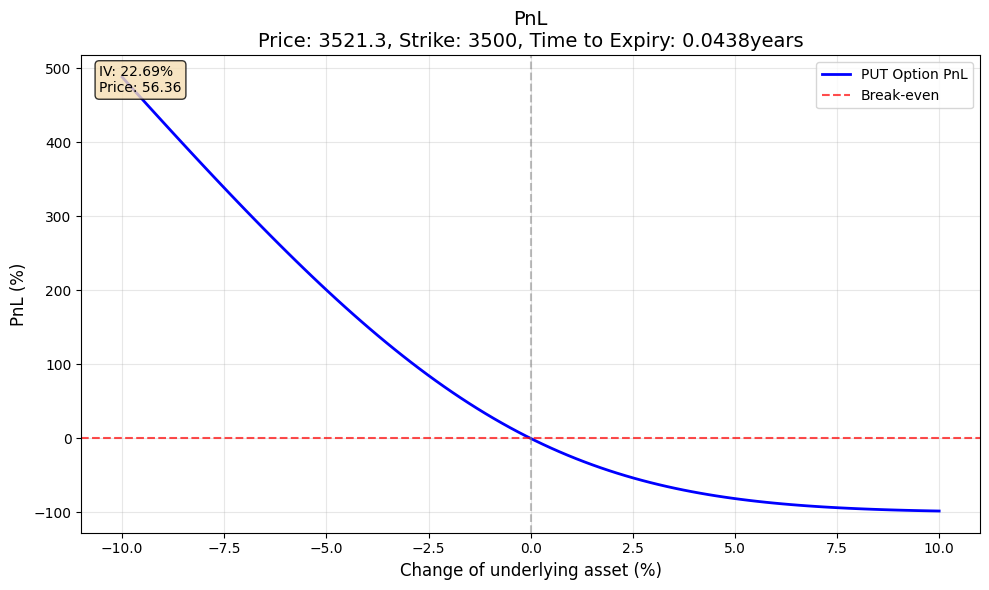

In [22]:
price_changes, pnls = plot_pnl_analysis(F, K, T, r, market_price, option_type)

In [27]:
T

0.043835616438356165

In [15]:
def vg_fft_pricing_futures(F, K, T, r, sigma, nu, theta, option_type='put'):
    """
    使用 FFT 方法计算基于期货的 VG 模型期权价格
    
    参数:
    F: 期货价格 (Forward Price)
    K: 行权价
    T: 到期时间（年）
    r: 无风险利率
    sigma: VG 扩散波动率
    nu: VG 方差率
    theta: VG 漂移参数
    option_type: 'call' 或 'put'
    """
    
    # 设置计算日期
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    # 计算到期日
    maturity_date = today + int(T * 365)
    
    # 创建期权 - 使用期货价格作为标的
    if option_type.lower() == 'call':
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
    else:
        payoff = ql.PlainVanillaPayoff(ql.Option.Put, K)
    
    exercise = ql.EuropeanExercise(maturity_date)
    option = ql.VanillaOption(payoff, exercise)
    
    # 创建利率曲线
    day_count = ql.Actual365Fixed()
    risk_free_curve = ql.YieldTermStructureHandle(
        ql.FlatForward(today, r, day_count)
    )
    
    # 对于期货期权，股息率应该等于无风险利率
    # 这样 F = S * exp((r-q)*T)，当 q=r 时，F = S，即期货价格就是当前"现货"价格
    dividend_curve = ql.YieldTermStructureHandle(
        ql.FlatForward(today, r, day_count)  # 股息率 = 无风险利率
    )
    
    # 创建 VG 过程 - 使用期货价格作为"现货"价格
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(F))
    vg_process = ql.VarianceGammaProcess(
        spot_handle,
        dividend_curve,  # q = r 用于期货
        risk_free_curve,
        sigma,
        nu,
        theta
    )
    
    # 创建 FFT 引擎
    fft_engine = ql.FFTVarianceGammaEngine(vg_process)
    option.setPricingEngine(fft_engine)
    
    return option.NPV()

In [16]:
vg_fft_pricing_futures(F, K, T, r, 0.25, 0.1, -0.05, option_type='put')

38.85423517845993

In [25]:
def calibrate_vg_multiple_options(option_data_list, F, r):
    """
    使用多个期权价格联合校准 VG 参数
    
    option_data_list: 包含多个期权信息的列表
    [{'K': 行权价, 'T': 到期时间, 'market_price': 市场价格, 'option_type': 'call'/'put'}, ...]
    """
    
    def objective_function(params):
        """目标函数：最小化所有期权的定价误差"""
        sigma, nu, theta = params
        
        if sigma <= 0 or nu <= 0:
            return 1e6
        
        total_error = 0
        for option_data in option_data_list:
            try:
                K = option_data['K']
                T = option_data['T'] 
                market_price = option_data['market_price']
                option_type = option_data['option_type']
                weight = option_data.get('weight', 1.0)  # 权重
                
                model_price = vg_fft_pricing_futures(F, K, T, r, sigma, nu, theta, option_type)
                
                # 相对误差平方（避免大价格期权占主导）
                relative_error = (model_price - market_price) / market_price
                total_error += weight * (relative_error ** 2)
                
            except:
                return 1e6
        
        return total_error
    
    # 参数约束
    bounds = [(0.01, 2.0), (0.001, 1.0), (-1.0, 1.0)]
    
    # 使用差分进化算法（适合多变量全局优化）
    result = differential_evolution(objective_function, bounds, 
                                  maxiter=200, seed=42, workers=1)
    
    if not result.success:
        raise ValueError("多期权校准失败")
    
    sigma_opt, nu_opt, theta_opt = result.x
    
    # 验证每个期权的拟合效果
    print(f"=== 多期权联合校准结果 ===")
    print(f"最优参数: σ={sigma_opt:.4f}, ν={nu_opt:.4f}, θ={theta_opt:.4f}")
    print(f"总优化误差: {result.fun:.6f}")
    print()
    
    results = []
    for i, option_data in enumerate(option_data_list):
        K = option_data['K']
        T = option_data['T']
        market_price = option_data['market_price']
        option_type = option_data['option_type']
        
        model_price = vg_fft_pricing_futures(F, K, T, r, sigma_opt, nu_opt, theta_opt, option_type)
        abs_error = abs(model_price - market_price)
        rel_error = abs_error / market_price * 100
        
        results.append({
            'option_id': i+1,
            'K': K, 'T': T, 'type': option_type,
            'market_price': market_price,
            'model_price': model_price,
            'abs_error': abs_error,
            'rel_error': rel_error
        })
        
        print(f"期权{i+1}: K={K}, T={T:.3f}, {option_type}")
        print(f"  市场价格: {market_price:.4f}, 模型价格: {model_price:.4f}")
        print(f"  误差: {abs_error:.4f} ({rel_error:.2f}%)")
    
    return {
        'sigma': sigma_opt,
        'nu': nu_opt,
        'theta': theta_opt,
        'total_error': result.fun,
        'individual_results': results
    }